# PART ONE
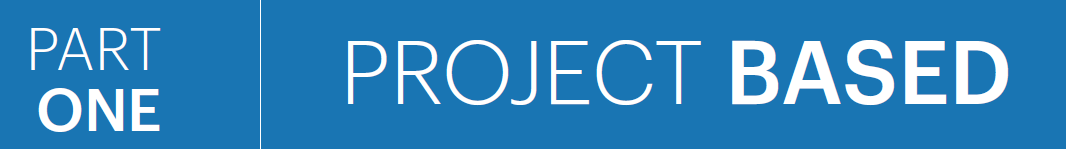

**DOMAIN**: Digital content management

• **CONTEXT**: Classification is probably the most popular task that you would deal with in real life. Text in the form of blogs, posts, articles,
etc. is written every second. It is a challenge to predict the information about the writer without knowing about him/her. We are going to
create a classifier that predicts multiple features of the author of a given text. We have designed it as a Multi label classification problem.

• **DATA DESCRIPTION:** Over 600,000 posts from more than 19 thousand bloggers The Blog Authorship Corpus consists of the collected
posts of 19,320 bloggers gathered from blogger.com in August 2004. The corpus incorporates a total of 681,288 posts and over 140 million
words - or approximately 35 posts and 7250 words per person. Each blog is presented as a separate file, the name of which indicates a
blogger id# and the blogger’s self-provided gender, age, industry, and astrological sign. (All are labelled for gender and age but for many,
industry and/or sign is marked as unknown.) All bloggers included in the corpus fall into one of three age groups:
• 8240 "10s" blogs (ages 13-17),
• 8086 "20s" blogs(ages 23-27) and
• 2994 "30s" blogs (ages 33-47)
For each age group, there is an equal number of male and female bloggers.
Each blog in the corpus includes at least 200 occurrences of common English words. All formatting has been stripped with two exceptions.
Individual posts within a single blogger are separated by the date of the following post and links within a post are denoted by the label url
link. Link to dataset: https://www.kaggle.com/rtatman/blog-authorship-corpus

• **PROJECT OBJECTIVE:** The need is to build a NLP classifier which can use input text parameters to determine the label/s of the blog.
Steps and tasks:
1. Import and analyse the data set.
2. Perform data pre-processing on the data:
• Data cleansing by removing unwanted characters, spaces, stop words etc. Convert text to lowercase.
• Target/label merger and transformation
• Train and test split
• Vectorisation, etc.
3. Design, train, tune and test the best text classifier.
4. Display and explain detail the classification report
5. Print the true vs predicted labels for any 5 entries from the dataset.

In [108]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


In [109]:
#import the reqired libraries
import random
random.seed(0)
# Ignore the warnings
import warnings
warnings.filterwarnings("ignore")
import os
import numpy as np
import pandas as pd
import seaborn as sns

%tensorflow_version 2.x
import tensorflow
import nltk 
nltk.download('stopwords')
tensorflow.__version__

from google.colab.patches import cv2_imshow
# Load the Drive helper and mount
from google.colab import drive
from sklearn.model_selection import train_test_split
from sklearn.decomposition import PCA
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.multiclass import OneVsRestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import MultiLabelBinarizer
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.svm import LinearSVC
from sklearn.naive_bayes import MultinomialNB


from gensim.models import Word2Vec

from nltk.tokenize import RegexpTokenizer
from nltk.corpus import stopwords
from matplotlib import pyplot
%matplotlib inline
import re

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [110]:
## read input csv
blogs=pd.read_csv("/content/drive/MyDrive/Colab Notebooks/NLP/blogtext.csv")

In [111]:
blogs.head()

,id,gender,age,topic,sign,date,text
0,2059027,male,15,Student,Leo,"14,May,2004",Info has been f...
1,2059027,male,15,Student,Leo,"13,May,2004",These are the t...
2,2059027,male,15,Student,Leo,"12,May,2004",In het kader va...
3,2059027,male,15,Student,Leo,"12,May,2004",testing!!! tes...
4,3581210,male,33,InvestmentBanking,Aquarius,"11,June,2004",Thanks to Yah...


In [112]:
#data is very large and Colab was going out of memory, just taking 5000 for easy processing 
blogs=blogs.head(4000)

In [113]:
blogs.shape

(4000, 7)

In [114]:
blogs.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4000 entries, 0 to 3999
Data columns (total 7 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   id      4000 non-null   int64 
 1   gender  4000 non-null   object
 2   age     4000 non-null   int64 
 3   topic   4000 non-null   object
 4   sign    4000 non-null   object
 5   date    4000 non-null   object
 6   text    4000 non-null   object
dtypes: int64(2), object(5)
memory usage: 218.9+ KB


In [115]:
blogs.isna().any()

id        False
gender    False
age       False
topic     False
sign      False
date      False
text      False
dtype: bool

In [116]:
## Removing id & date
blogs.drop(['id','date'], axis=1, inplace=True)

In [117]:
## clean data
#remove non alpha char's like special char
blogs['cleanText']=blogs['text'].apply(lambda x: re.sub(r'[^A-Za-z]+',' ',x))
#convert to lowercase
blogs['cleanText']=blogs['cleanText'].apply(lambda x: x.lower())
#remove begin and end chars
blogs['cleanText']=blogs['cleanText'].apply(lambda x: x.strip())

In [118]:
# remove Stopwords
nltk.download('stopwords')
from nltk.corpus import stopwords # Remove stop words
stopwords=set(stopwords.words('english'))

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [119]:
blogs['cleanText']=blogs['cleanText'].apply(lambda x: ' '.join([words for words in x.split() if words not in stopwords]))

### Data analysis

In [120]:
blogs.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4000 entries, 0 to 3999
Data columns (total 6 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   gender     4000 non-null   object
 1   age        4000 non-null   int64 
 2   topic      4000 non-null   object
 3   sign       4000 non-null   object
 4   text       4000 non-null   object
 5   cleanText  4000 non-null   object
dtypes: int64(1), object(5)
memory usage: 187.6+ KB


In [121]:
pd.set_option('display.max_colwidth', 30)
blogs.head(5).T

,0,1,2,3,4
gender,male,male,male,male,male
age,15,15,15,15,33
topic,Student,Student,Student,Student,InvestmentBanking
sign,Leo,Leo,Leo,Leo,Aquarius
text,Info has been f...,These are the t...,In het kader va...,testing!!! tes...,Thanks to Yah...
cleanText,info found pages mb pdf fi...,team members drewes van de...,het kader van kernfusie op...,testing testing,thanks yahoo toolbar captu...


In [122]:
print(blogs.describe(include = [np.number]).T)
print('\n\n',blogs.age.value_counts())

      count    mean       std   min   25%   50%   75%   max
age  4000.0  29.929  7.726991  14.0  24.0  35.0  35.0  45.0


 35    2307
24     347
15     319
17     191
25     157
14     129
23     106
33      94
27      86
39      79
36      60
26      43
16      26
37      19
41      14
45      14
34       6
44       3
Name: age, dtype: int64


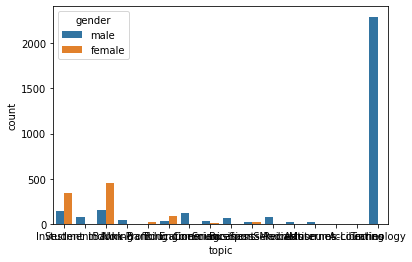

In [123]:
sns.countplot(x="topic", hue="gender", data=blogs, )

#### most of the bloggers in age of 35

In [124]:
blogs.describe(include = [np.object]).T

,count,unique,top,freq
gender,4000,2,male,3081
topic,4000,16,Technology,2294
sign,4000,12,Aries,2449
text,4000,3989,,6
cleanText,4000,3975,,10


#### most are males in the subset data, most blogs are on Tech and sun_sign is Aries

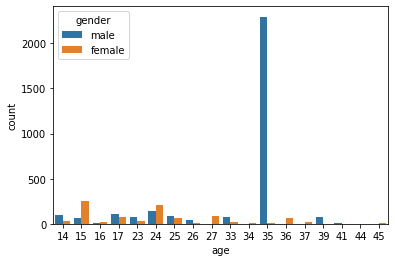

In [125]:
sns.countplot(x="age", hue="gender", data=blogs)

In [126]:
#creating a new feature called 'labels' by merging feature for processing
#as we want this to be a multi-label classification problem 
blogs['labels']=blogs.apply(lambda col: [col['gender'],str(col['age']),col['topic'],col['sign']], axis=1)

In [127]:
blogs.head()

,gender,age,topic,sign,text,cleanText,labels
0,male,15,Student,Leo,Info has been f...,info found pages mb pdf fi...,"[male, 15, Student, Leo]"
1,male,15,Student,Leo,These are the t...,team members drewes van de...,"[male, 15, Student, Leo]"
2,male,15,Student,Leo,In het kader va...,het kader van kernfusie op...,"[male, 15, Student, Leo]"
3,male,15,Student,Leo,testing!!! tes...,testing testing,"[male, 15, Student, Leo]"
4,male,33,InvestmentBanking,Aquarius,Thanks to Yah...,thanks yahoo toolbar captu...,"[male, 33, InvestmentBanki..."


In [128]:
blogs_df = blogs[['cleanText','labels']]

In [129]:
blogs_df.head()

,cleanText,labels
0,info found pages mb pdf fi...,"[male, 15, Student, Leo]"
1,team members drewes van de...,"[male, 15, Student, Leo]"
2,het kader van kernfusie op...,"[male, 15, Student, Leo]"
3,testing testing,"[male, 15, Student, Leo]"
4,thanks yahoo toolbar captu...,"[male, 33, InvestmentBanki..."


In [130]:
#Split data
X = blogs_df['cleanText']
Y = blogs_df['labels']

In [131]:
#split data for training and testing
Xtrain,Xtest,Ytrain,Ytest=train_test_split(X,Y,test_size=0.25)

In [132]:
#creating a bag of words and using a count vectorizer
vectorizer=CountVectorizer(binary=True, ngram_range=(1,2))

In [133]:
vectorizer.fit(Xtrain)
len(vectorizer.vocabulary_)

215827

In [134]:
vectorizer.get_feature_names_out()[:10]

array(['aa', 'aa anger', 'aa compared', 'aa nice', 'aaa', 'aaa take',
       'aaa travel', 'aaaaaah', 'aaaaack', 'aaaah'], dtype=object)

In [135]:
blogs.labels.values

array([list(['male', '15', 'Student', 'Leo']),
       list(['male', '15', 'Student', 'Leo']),
       list(['male', '15', 'Student', 'Leo']), ...,
       list(['male', '25', 'Arts', 'Aries']),
       list(['male', '14', 'Student', 'Leo']),
       list(['male', '14', 'Student', 'Leo'])], dtype=object)

In [136]:
X_train_ct = vectorizer.transform(Xtrain)
X_test_ct = vectorizer.transform(Xtest)

In [137]:
print(X_train_ct)

  (0, 1770)	1
  (0, 1773)	1
  (0, 4108)	1
  (0, 4116)	1
  (0, 4125)	1
  (0, 10505)	1
  (0, 10561)	1
  (0, 11042)	1
  (0, 11044)	1
  (0, 18009)	1
  (0, 18023)	1
  (0, 18036)	1
  (0, 18050)	1
  (0, 26176)	1
  (0, 26185)	1
  (0, 28651)	1
  (0, 28652)	1
  (0, 29157)	1
  (0, 33354)	1
  (0, 33358)	1
  (0, 34038)	1
  (0, 34068)	1
  (0, 38159)	1
  (0, 38385)	1
  (0, 39224)	1
  :	:
  (2999, 167558)	1
  (2999, 167700)	1
  (2999, 167720)	1
  (2999, 167739)	1
  (2999, 167740)	1
  (2999, 167741)	1
  (2999, 168932)	1
  (2999, 168933)	1
  (2999, 174320)	1
  (2999, 174324)	1
  (2999, 181980)	1
  (2999, 182883)	1
  (2999, 183082)	1
  (2999, 187533)	1
  (2999, 187552)	1
  (2999, 187707)	1
  (2999, 193581)	1
  (2999, 193593)	1
  (2999, 196341)	1
  (2999, 196351)	1
  (2999, 197206)	1
  (2999, 197207)	1
  (2999, 211299)	1
  (2999, 211318)	1
  (2999, 211362)	1


In [138]:
#The key will be label name and value will be the total count of the label. Check below image for reference
label_counts=dict()

for labels in blogs.labels.values:
    for label in labels:
        if label in label_counts:
            label_counts[label]+=1
        else:
            label_counts[label]=1

In [139]:
label_counts

{'14': 129,
 '15': 319,
 '16': 26,
 '17': 191,
 '23': 106,
 '24': 347,
 '25': 157,
 '26': 43,
 '27': 86,
 '33': 94,
 '34': 6,
 '35': 2307,
 '36': 60,
 '37': 19,
 '39': 79,
 '41': 14,
 '44': 3,
 '45': 14,
 'Accounting': 2,
 'Aquarius': 291,
 'Aries': 2449,
 'Arts': 20,
 'Banking': 16,
 'BusinessServices': 43,
 'Cancer': 79,
 'Capricorn': 77,
 'Communications-Media': 61,
 'Education': 118,
 'Engineering': 119,
 'Gemini': 35,
 'Internet': 20,
 'InvestmentBanking': 70,
 'Leo': 111,
 'Libra': 360,
 'Museums-Libraries': 2,
 'Non-Profit': 46,
 'Pisces': 67,
 'Sagittarius': 117,
 'Science': 33,
 'Scorpio': 292,
 'Sports-Recreation': 75,
 'Student': 476,
 'Taurus': 83,
 'Technology': 2294,
 'Virgo': 39,
 'female': 919,
 'indUnk': 605,
 'male': 3081}

In [140]:
# preProcessing labels
binarizer=MultiLabelBinarizer(classes=sorted(label_counts.keys()))

In [141]:
Ytrain=binarizer.fit_transform(Ytrain)

In [142]:
Ytest = binarizer.transform(Ytest)

In [143]:
#logistic regression
model=LogisticRegression(solver='lbfgs')

In [144]:
model=OneVsRestClassifier(model)

In [145]:
model.fit(X_train_ct,Ytrain)

OneVsRestClassifier(estimator=LogisticRegression())

In [146]:
Ypred=model.predict(X_test_ct)

In [148]:
from sklearn.metrics import accuracy_score
from sklearn.metrics import f1_score
from sklearn.metrics import average_precision_score
from sklearn.metrics import recall_score

def display_metrics_micro(Ytest, Ypred):
    print('Accuracy score: ', accuracy_score(Ytest, Ypred))
    print('F1 score: Micro', f1_score(Ytest, Ypred, average='micro'))
    print('Average precision score: Micro', average_precision_score(Ytest, Ypred, average='micro'))
    print('Average recall score: Micro', recall_score(Ytest, Ypred, average='micro'))
    
    
def display_metrics_macro(Ytest, Ypred):
    print('Accuracy score: ', accuracy_score(Ytest, Ypred))
    print('F1 score: Macro', f1_score(Ytest, Ypred, average='macro'))
    print('Average recall score: MAcro', recall_score(Ytest, Ypred, average='macro'))
    
def display_metrics_weighted(Ytest, Ypred):
    print('Accuracy score: ', accuracy_score(Ytest, Ypred))
    print('F1 score: weighted', f1_score(Ytest, Ypred, average='weighted'))
    print('Average precision score: weighted', average_precision_score(Ytest, Ypred, average='weighted'))
    print('Average recall score: weighted', recall_score(Ytest, Ypred, average='weighted'))

In [149]:
display_metrics_micro(Ytest,Ypred)

Accuracy score:  0.592
F1 score: Micro 0.7707558859975217
Average precision score: Micro 0.6252660831034835
Average recall score: Micro 0.69975


In [156]:
display_metrics_macro(Ytest,Ypred)

Accuracy score:  0.592
F1 score: Macro 0.21484454241783935
Average recall score: MAcro 0.1724005962206959


In [157]:
display_metrics_weighted(Ytest,Ypred)

Accuracy score:  0.592
F1 score: weighted 0.6999996256262024
Average precision score: weighted 0.6402568348605121
Average recall score: weighted 0.69975


In [150]:
Ypred_inversed = binarizer.inverse_transform(Ypred)
y_test_inversed = binarizer.inverse_transform(Ytest)

####Print the true vs predicted labels for any 5 entries from the dataset.

In [151]:
#using model predict details of the blogger 
for i in range(5):
    print('True labels:\t{}\n Predicted labels:\t{}\n\n'.format(y_test_inversed[i],Ypred_inversed[i]) )

True labels:	('35', 'Aries', 'Technology', 'male')
 Predicted labels:	('35', 'Aries', 'Technology', 'male')


True labels:	('35', 'Aries', 'Technology', 'male')
 Predicted labels:	('35', 'Aries', 'Technology', 'male')


True labels:	('35', 'Aries', 'Technology', 'male')
 Predicted labels:	('35', 'Aries', 'Technology', 'male')


True labels:	('35', 'Aries', 'Technology', 'male')
 Predicted labels:	('35', 'Aries', 'Technology', 'male')


True labels:	('35', 'Aries', 'Technology', 'male')
 Predicted labels:	('35', 'Aries', 'Technology', 'male')




####Display and explain detail the classification report

In [158]:
from sklearn.metrics import accuracy_score
from sklearn.metrics import f1_score
from sklearn.metrics import average_precision_score
from sklearn.metrics import recall_score

def print_evaluation_scores(Ytest, Ypred):
    print('Accuracy score: ', accuracy_score(Ytest, Ypred))
    print('F1 score: ', f1_score(Ytest, Ypred, average='micro'))
    print('Average precision score: ', average_precision_score(Ytest, Ypred, average='micro'))
    print('Average recall score: ', recall_score(Ytest, Ypred, average='micro'))

In [160]:
print("The Better result")
print_evaluation_scores(Ytest, Ypred)

The Better result
Accuracy score:  0.592
F1 score:  0.7707558859975217
Average precision score:  0.6252660831034835
Average recall score:  0.69975


In [154]:
def build_model_train(X_train, y_train, X_valid=None, y_valid=None, C=1.0, model='lr'):
    if model=='lr':
        model = LogisticRegression(C=C, penalty='l1', dual=False, solver='liblinear')
        model = OneVsRestClassifier(model)
        model.fit(X_train, y_train)
    
    elif model=='svm':
        model = LinearSVC(C=C, penalty='l1', dual=False, loss='squared_hinge')
        model = OneVsRestClassifier(model)
        model.fit(X_train, y_train)
    
    elif model=='nbayes':
        model = MultinomialNB(alpha=1.0)
        model = OneVsRestClassifier(model)
        model.fit(X_train, y_train)
        
    elif model=='lda':
        model = LinearDiscriminantAnalysis(solver='svd')
        model = OneVsRestClassifier(model)
        model.fit(X_train, y_train)

    return model


In [165]:
models = ['lr','svm','nbayes']
for model in models:
    model = build_model_train(X_train_ct,Ytrain,model=model)
    model.fit(X_train_ct,Ytrain)
    Ypred=model.predict(X_test_ct)
    print("\n")
    print(f"metrics for {model}\n")
    display_metrics_micro(Ytest,Ypred)
    print("-----------------------")
    display_metrics_macro(Ytest,Ypred)
    print("-----------------------")
    display_metrics_weighted(Ytest,Ypred)
    print("#######################")



metrics for OneVsRestClassifier(estimator=LogisticRegression(penalty='l1',
                                                 solver='liblinear'))

Accuracy score:  0.603
F1 score: Micro 0.7922821024617432
Average precision score: Micro 0.6516488442389757
Average recall score: Micro 0.74425
-----------------------
Accuracy score:  0.603
F1 score: Macro 0.4468128906782294
Average recall score: MAcro 0.3646588495524255
-----------------------
Accuracy score:  0.603
F1 score: weighted 0.7574702267682314
Average precision score: weighted 0.6781355370194624
Average recall score: weighted 0.74425
#######################


metrics for OneVsRestClassifier(estimator=LinearSVC(dual=False, penalty='l1'))

Accuracy score:  0.59
F1 score: Micro 0.7944773175542406
Average precision score: Micro 0.6532974283402682
Average recall score: Micro 0.75525
-----------------------
Accuracy score:  0.59
F1 score: Macro 0.48613676412933926
Average recall score: MAcro 0.41312394816328785
-----------------------

### LogisticRegression is giving comparatively better result as shwon above.

# Part Two
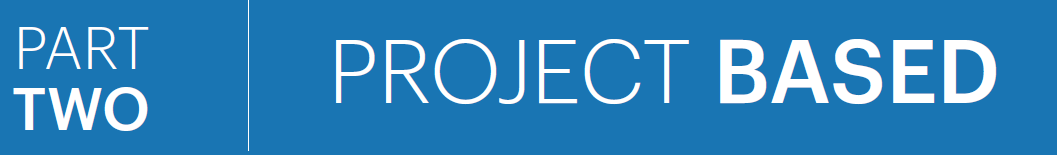

**DOMAIN:** Customer support

• **CONTEXT:** Great Learning has a an academic support department which receives numerous support requests every day throughout the
year. Teams are spread across geographies and try to provide support round the year. Sometimes there are circumstances where due to
heavy workload certain request resolutions are delayed, impacting company’s business. Some of the requests are very generic where a
proper resolution procedure delivered to the user can solve the problem. Company is looking forward to design an automation which can
interact with the user, understand the problem and display the resolution procedure [ if found as a generic request ] or redirect the request
to an actual human support executive if the request is complex or not in it’s database.

• **DATA DESCRIPTION:** A sample corpus is attached for your reference. Please enhance/add more data to the corpus using your linguistics
skills.

• **PROJECT OBJECTIVE:** Design a python based interactive semi - rule based chatbot which can do the following:
1. Start chat session with greetings and ask what the user is looking for.
2. Accept dynamic text based questions from the user. Reply back with relevant answer from the designed corpus.
3. End the chat session only if the user requests to end else ask what the user is looking for. Loop continues till the user asks to end it.

In [180]:
import json
import string
import random 
import nltk
import numpy as np
from nltk.stem import WordNetLemmatizer 
import tensorflow as tf 
from tensorflow.keras import Sequential 
from tensorflow.keras.layers import Dense, Dropout
nltk.download("punkt")
nltk.download("wordnet")

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

In [181]:
from nltk.chat.util import Chat, reflections

In [182]:
# importing the module
import json
  
# Opening JSON file
with open('/content/drive/MyDrive/Colab Notebooks/NLP/GLBotUpdated.json') as json_file:
    data = json.load(json_file)

In [183]:
# Print the type of data variable
print("Type:", type(data))

Type: <class 'dict'>


In [184]:
# lemmatizer to get stem of words
lemmatizer = WordNetLemmatizer()
# Each list to create
words = []
classes = []
doc_X = []
doc_y = []

# Loop through all the intents
# tokenize each pattern and append tokens to words, the patterns and
# the associated tag to their associated list
for intent in data["intents"]:
    for pattern in intent["patterns"]:
        tokens = nltk.word_tokenize(pattern)
        words.extend(tokens)
        doc_X.append(pattern)
        doc_y.append(intent["tag"])
    
    # add the tag to the classes if it's not there already 
    if intent["tag"] not in classes:
        classes.append(intent["tag"])

# lemmatize all the words in the vocab and convert them to lowercase
# if the words don't appear in punctuation
words = [lemmatizer.lemmatize(word.lower()) for word in words if word not in string.punctuation]

# sorting the vocab and classes in alphabetical order and taking the # set to ensure no duplicates occur
words = sorted(set(words))
classes = sorted(set(classes))

In [185]:
print(words)

['a', 'able', 'access', 'activation', 'ada', 'adam', 'ahoy', 'aifl', 'aiml', 'am', 'an', 'ann', 'anyone', 'are', 'artificial', 'backward', 'bad', 'bagging', 'batch', 'bayes', 'belong', 'best', 'blended', 'bloody', 'boosting', 'bot', 'buddy', 'bye', 'classification', 'contact', 'create', 'cross', 'cya', 'day', 'deep', 'did', 'diffult', 'do', 'ensemble', 'epoch', 'explain', 'first', 'for', 'forest', 'forward', 'from', 'function', 'good', 'goodbye', 'gradient', 'great', 'hate', 'have', 'hell', 'hello', 'help', 'helped', 'hey', 'hi', 'hidden', 'hour', 'how', 'hyper', 'i', 'imputer', 'in', 'intelligence', 'is', 'jerk', 'joke', 'knn', 'later', 'layer', 'learner', 'learning', 'leaving', 'link', 'listen', 'logistic', 'lot', 'machine', 'me', 'ml', 'my', 'naive', 'namaste', 'name', 'nb', 'net', 'network', 'neural', 'no', 'not', 'of', 'olympus', 'olypus', 'on', 'online', 'operation', 'opertions', 'otimizer', 'parameter', 'piece', 'please', 'pm', 'problem', 'propagation', 'random', 'regression', '

In [186]:
print(classes)

['Bot', 'Exit', 'Intro', 'NN', 'Olympus', 'Profane', 'SL', 'Ticket']


In [187]:
print(doc_X)

['hi', 'how are you', 'is anyone there', 'hello', 'whats up', 'hey', 'yo', 'listen', 'please help me', 'i am learner from', 'i belong to', 'aiml batch', 'aifl batch', 'i am from', 'my pm is', 'blended', 'online', 'i am from', 'hey ya', 'ahoy', 'namaste', 'talking to you for first time', 'thank you', 'thanks', 'cya', 'see you', 'later', 'see you later', 'goodbye', 'bye', 'i am leaving', 'have a Good day', 'you helped me', 'thanks a lot', 'thanks a ton', 'you are the best', 'great help', 'too good', 'you are a good learning buddy', 'olympus', 'explain me how olympus works', 'I am not able to understand olympus', 'olympus window not working', 'no access to olympus', 'unable to see link in olympus', 'no link visible on olympus', 'whom to contact for olympus', 'lot of problem with olympus', 'olypus is not a good tool', 'lot of problems with olympus', 'how to use olympus', 'teach me olympus', 'i am not able to understand svm', 'explain me how machine learning works', 'i am not able to unders

In [188]:
print(doc_y)

['Intro', 'Intro', 'Intro', 'Intro', 'Intro', 'Intro', 'Intro', 'Intro', 'Intro', 'Intro', 'Intro', 'Intro', 'Intro', 'Intro', 'Intro', 'Intro', 'Intro', 'Intro', 'Intro', 'Intro', 'Intro', 'Intro', 'Exit', 'Exit', 'Exit', 'Exit', 'Exit', 'Exit', 'Exit', 'Exit', 'Exit', 'Exit', 'Exit', 'Exit', 'Exit', 'Exit', 'Exit', 'Exit', 'Exit', 'Olympus', 'Olympus', 'Olympus', 'Olympus', 'Olympus', 'Olympus', 'Olympus', 'Olympus', 'Olympus', 'Olympus', 'Olympus', 'Olympus', 'Olympus', 'SL', 'SL', 'SL', 'SL', 'SL', 'SL', 'SL', 'SL', 'SL', 'SL', 'SL', 'SL', 'SL', 'SL', 'SL', 'SL', 'SL', 'SL', 'SL', 'SL', 'SL', 'SL', 'SL', 'SL', 'SL', 'SL', 'SL', 'SL', 'SL', 'NN', 'NN', 'NN', 'NN', 'NN', 'NN', 'NN', 'NN', 'NN', 'NN', 'NN', 'NN', 'NN', 'NN', 'NN', 'NN', 'NN', 'NN', 'NN', 'NN', 'NN', 'NN', 'NN', 'NN', 'Bot', 'Bot', 'Bot', 'Bot', 'Bot', 'Bot', 'Bot', 'Bot', 'Profane', 'Profane', 'Profane', 'Profane', 'Profane', 'Profane', 'Profane', 'Profane', 'Profane', 'Ticket', 'Ticket', 'Ticket', 'Ticket', 'Ticket',

In [189]:
# list for training data
training = []
out_empty = [0] * len(classes)
# creating the bag of words model
for idx, doc in enumerate(doc_X):
    bow = []
    text = lemmatizer.lemmatize(doc.lower())
    for word in words:
        bow.append(1) if word in text else bow.append(0)
    # mark the index of class that the current pattern is associated
    # to
    output_row = list(out_empty)
    output_row[classes.index(doc_y[idx])] = 1
    # add the one hot encoded BoW and associated classes to training 
    training.append([bow, output_row])
# shuffle the data and convert it to an array
random.shuffle(training)
training = np.array(training, dtype=object)
# split the features and target labels
train_X = np.array(list(training[:, 0]))
train_y = np.array(list(training[:, 1]))

In [190]:
# defining some parameters
input_shape = (len(train_X[0]),)
output_shape = len(train_y[0])
epochs = 200
# the deep learning model
model = Sequential()
model.add(Dense(128, input_shape=input_shape, activation="relu"))
model.add(Dropout(0.5))
model.add(Dense(64, activation="relu"))
model.add(Dropout(0.3))
model.add(Dense(output_shape, activation = "softmax"))
adam = tf.keras.optimizers.Adam(learning_rate=0.01, decay=1e-6)
model.compile(loss='categorical_crossentropy',
              optimizer=adam,
              metrics=["accuracy"])
print(model.summary())
model.fit(x=train_X, y=train_y, epochs=200, verbose=1)

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_9 (Dense)             (None, 128)               20736     
                                                                 
 dropout_6 (Dropout)         (None, 128)               0         
                                                                 
 dense_10 (Dense)            (None, 64)                8256      
                                                                 
 dropout_7 (Dropout)         (None, 64)                0         
                                                                 
 dense_11 (Dense)            (None, 8)                 520       
                                                                 
Total params: 29,512
Trainable params: 29,512
Non-trainable params: 0
_________________________________________________________________
None
Epoch 1/200
5/5 [============================

In [191]:
def clean_text(text): 
  tokens = nltk.word_tokenize(text)
  tokens = [lemmatizer.lemmatize(word) for word in tokens]
  return tokens

def bag_of_words(text, vocab): 
  tokens = clean_text(text)
  bow = [0] * len(vocab)
  for w in tokens: 
    for idx, word in enumerate(vocab):
      if word == w: 
        bow[idx] = 1
  return np.array(bow)

def pred_class(text, vocab, labels): 
  bow = bag_of_words(text, vocab)
  result = model.predict(np.array([bow]))[0]
  thresh = 0.2
  y_pred = [[idx, res] for idx, res in enumerate(result) if res > thresh]

  y_pred.sort(key=lambda x: x[1], reverse=True)
  return_list = []
  for r in y_pred:
    return_list.append(labels[r[0]])
  return return_list

def get_response(intents_list, intents_json): 
  tag = intents_list[0]
  list_of_intents = intents_json["intents"]
  for i in list_of_intents: 
    if i["tag"] == tag:
      result = random.choice(i["responses"])
      break
  return result

In [192]:
# running the chatbot
print("Hello! I am Byju's :). how can i help you today?")
flag=True
while (flag==True):
    message = input("")
    message = message.lower()
    intents = pred_class(message, words, classes)
    result = get_response(intents, data)
    print(result)
    if(intents[0]=='Exit'):
      flag=False


Hello! I am Byju's :). how can i help you today?
hi
Hello! how can i help you ?
we
A neural network is a series of algorithms that endeavors to recognize underlying relationships in a set of data through a process that mimics the way the human brain operates. In this sense, neural networks refer to systems of neurons, either organic or artificial in nature. To know more visit https://www.greatlearning.in/academy/learn-for-free/courses/introduction-to-neural-networks-and-deep-learning
namaste
Hello! how can i help you ?
ANN
A neural network is a series of algorithms that endeavors to recognize underlying relationships in a set of data through a process that mimics the way the human brain operates. In this sense, neural networks refer to systems of neurons, either organic or artificial in nature. To know more visit https://www.greatlearning.in/academy/learn-for-free/courses/introduction-to-neural-networks-and-deep-learning
ann
A neural network is a series of algorithms that endeavors to 